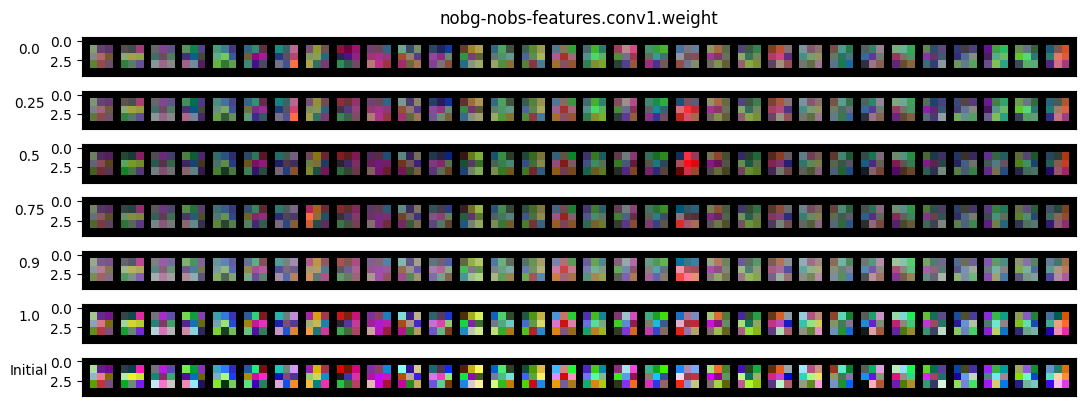

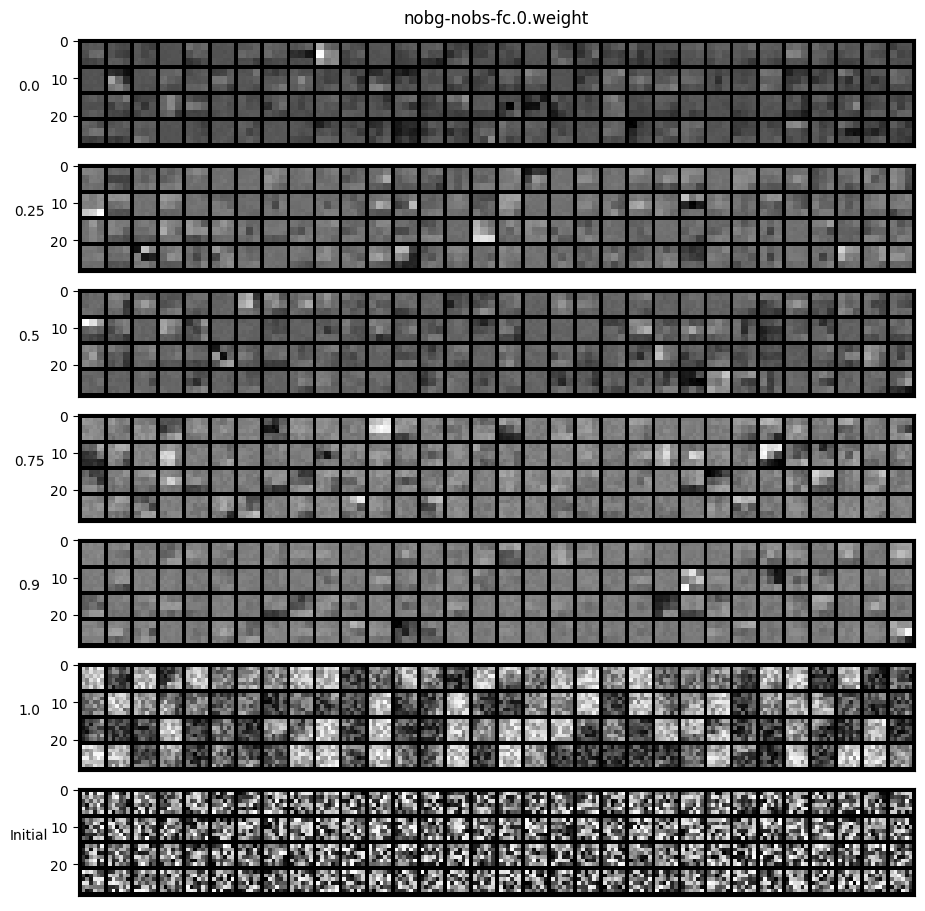

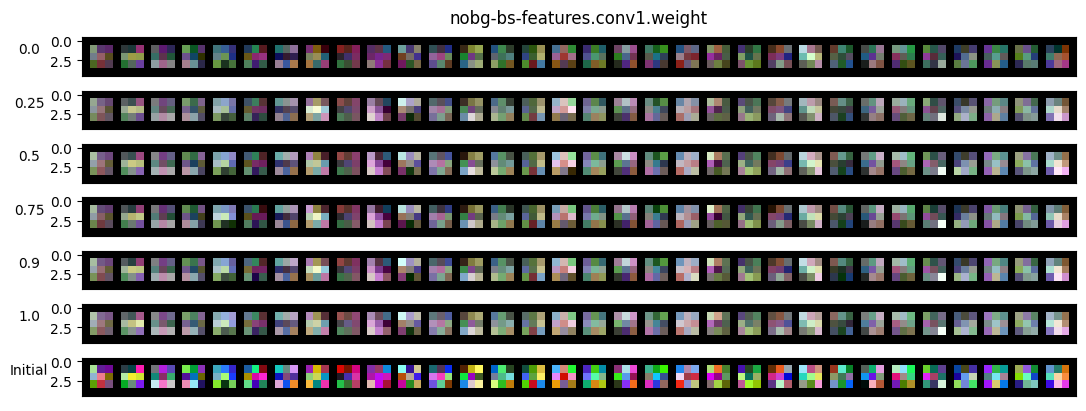

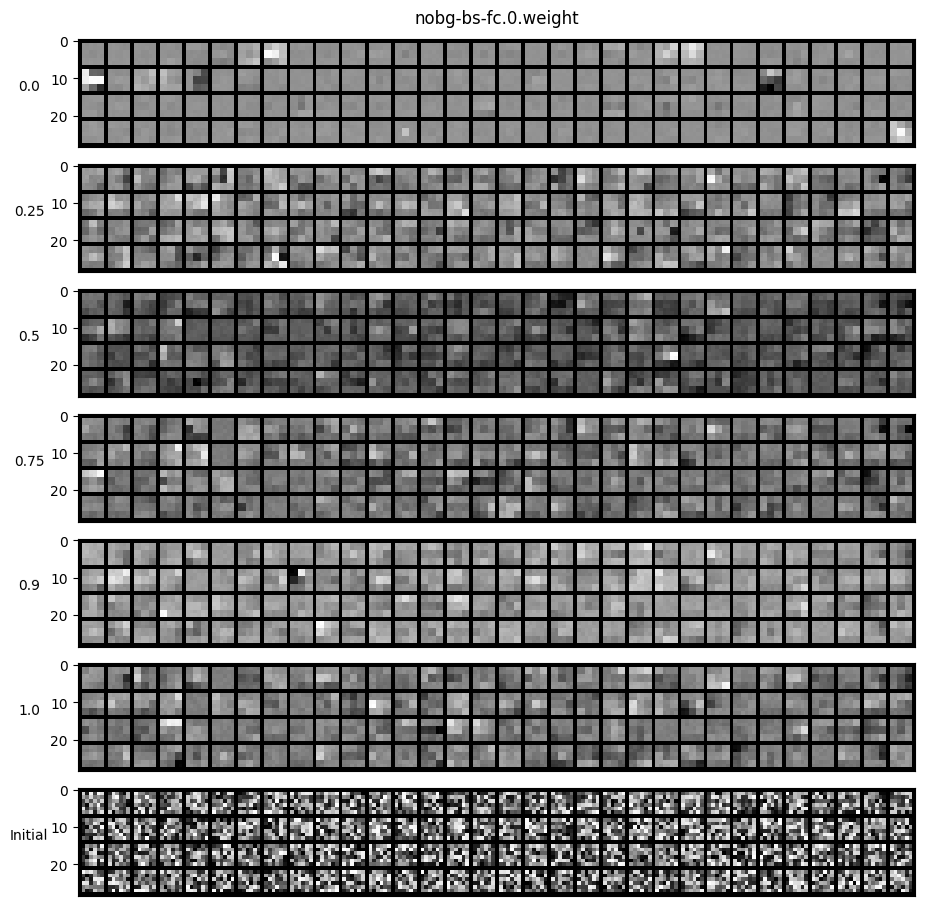

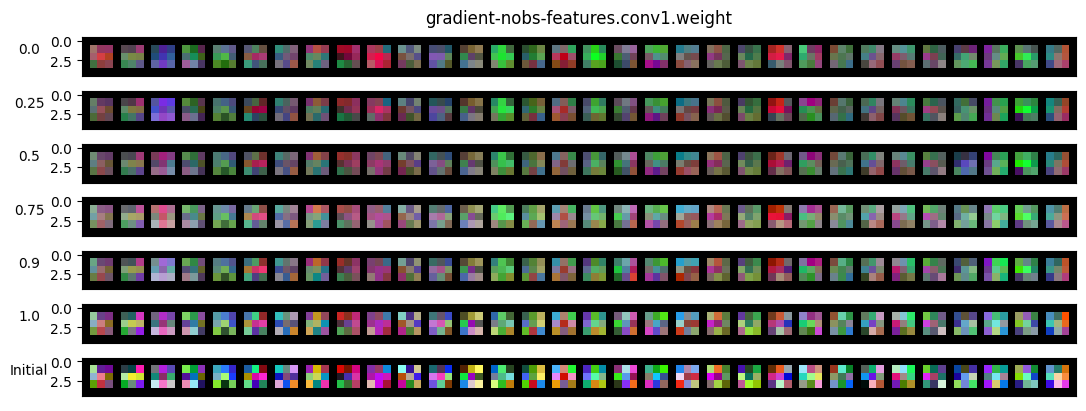

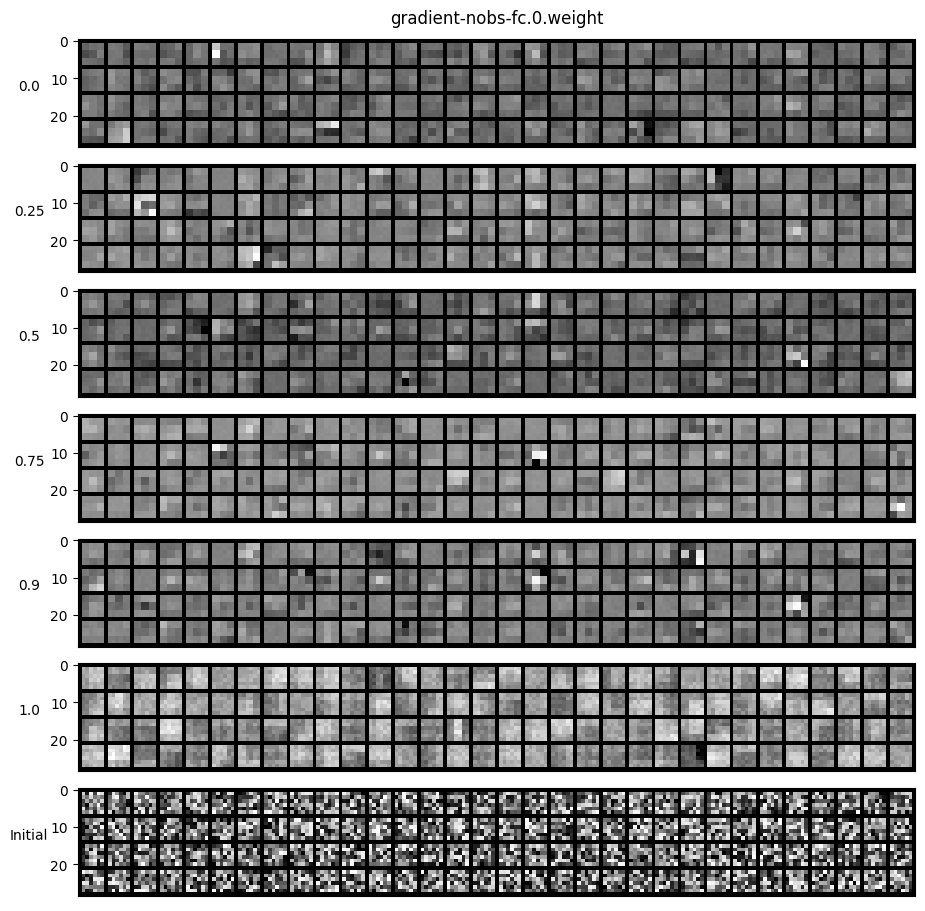

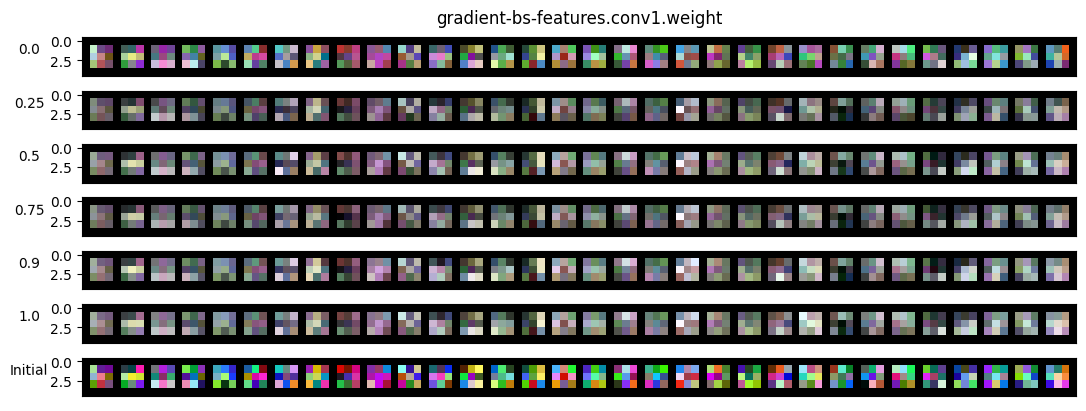

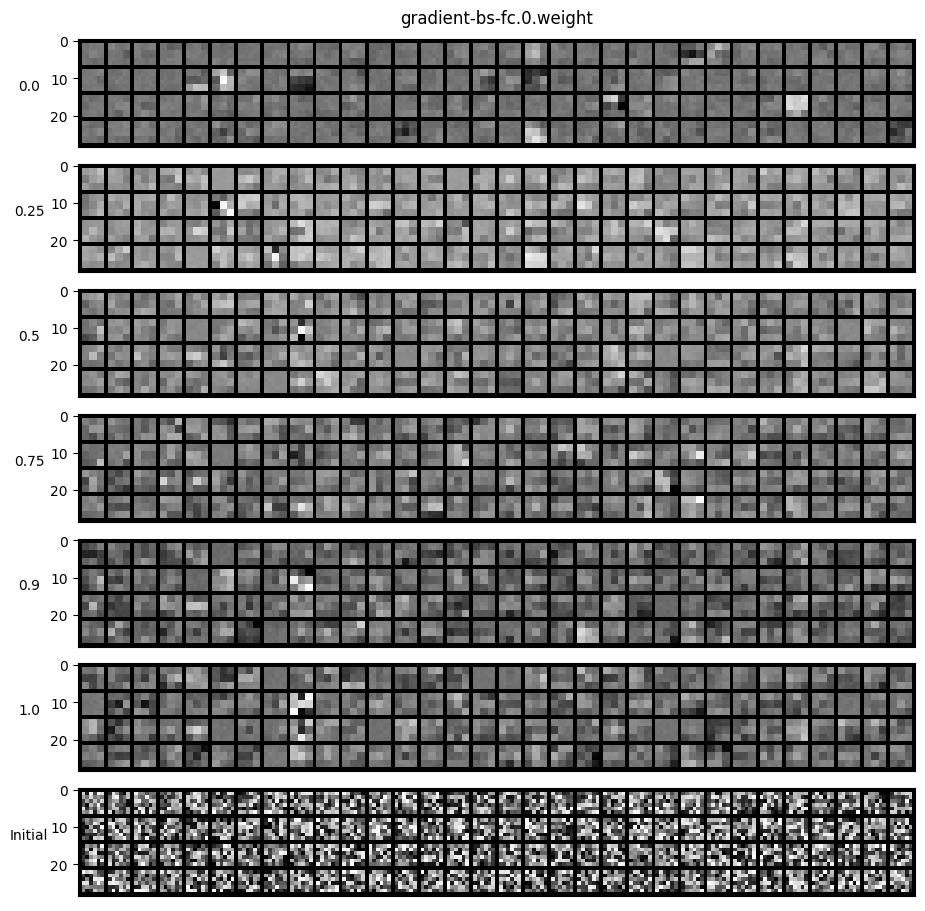

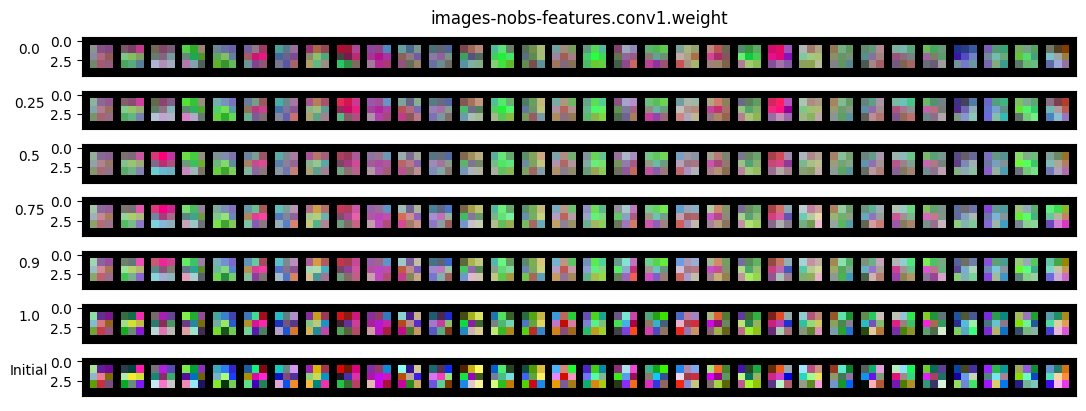

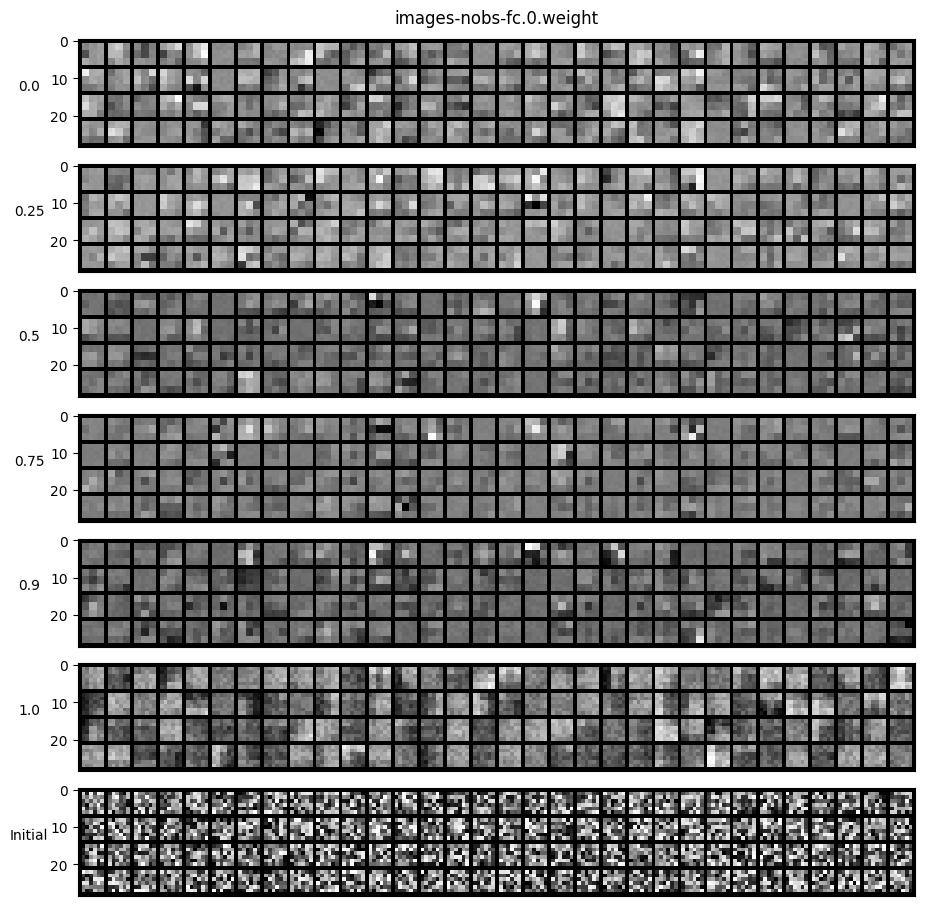

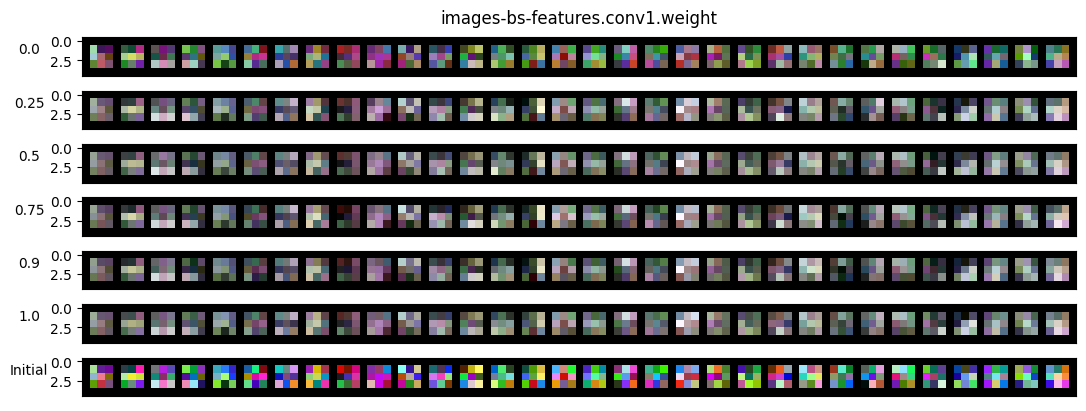

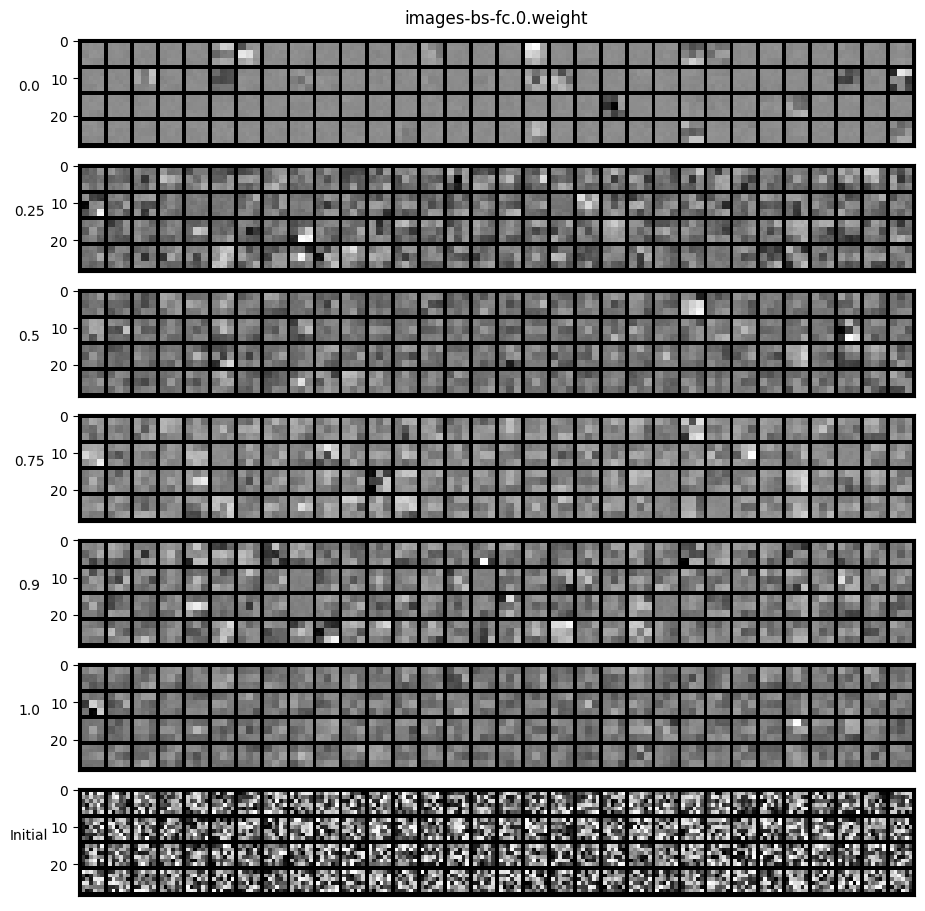

In [1]:
import torch
from easydict import EasyDict as edict
from models import simplecnn
from os.path import join
import torchvision
import matplotlib.pyplot as plt
from utils import set_random_state
def extract_weights(model, layer):
    for n, p in model.named_parameters():
        if n == layer:
            return p

root_models = "models"
args = edict()
args.seed = 222
model = simplecnn(args)
envs = ['nobg','gradient','images']
bgs = ["nobs", "bs"]
spurs = [0.5, 0.625, 0.75, 0.875, 0.95, 1]
layers = ['features.conv1.weight','fc.0.weight']
layer_shape = {
    'features.conv1.weight': (-1, 3, 3, 3),
    'features.conv2.weight': (-1, 1, 3, 3),
    'features.conv3.weight': (-1, 1, 3, 3),
    'fc.0.weight': (-1, 1, 6, 6)  
}

layer_height = {
    'features.conv1.weight': 4,
    'features.conv2.weight': 64*3,
    'features.conv3.weight': 256*3,
    'fc.0.weight': 9 
}
for env in envs:
    for bg in bgs:
        for layer in layers:
            model_list = [f"scnn_synmnist_{spur}_{env}_{bg}_cmnist_baseline.pth" for spur in spurs]
            fig, axs = plt.subplots(len(model_list)+1, constrained_layout=True)
            fig.set_size_inches(18.5, layer_height[layer])
            for i, mod in enumerate(model_list):
                p = round(float(mod.split("_")[2])*2 - 1,2)
                model_weights = torch.load(join(root_models, mod))
                model.load_state_dict(model_weights)
                w = extract_weights(model,layer)
                w = w.view(layer_shape[layer])
                #print(w.shape)
                grid = torchvision.utils.make_grid(w, normalize=True, nrow=32, scale_each=False, padding=1)
                #fig = plt.gcf()
                #fig.set_size_inches(18.5, 10.5)
                axs[i].imshow(grid.permute(1,2,0))
                #axs[i].axis('off')
                axs[i].axis('on')
                axs[i].xaxis.set_visible(False)

                axs[i].set_ylabel(p, labelpad=15, rotation=0.5)
            # Load initial weights
            set_random_state(args)
            model = simplecnn(args)

            #model.load_state_dict(model_weights)
            w = extract_weights(model, layer)
            w = w.view(layer_shape[layer])
            #print(w.shape)
            grid = torchvision.utils.make_grid(w, normalize=True, nrow=32, padding=1)
            #fig = plt.gcf()
            #fig.set_size_inches(18.5, 10.5)
            axs[-1].imshow(grid.permute(1,2,0))
            #axs[i].axis('off')
            axs[-1].axis('on')
            axs[-1].xaxis.set_visible(False)
            axs[-1].set_ylabel("Initial", labelpad=15, rotation=0.5)
            fig.suptitle(f"{env}-{bg}-{layer}")



# How necessary is it to train the first layer of the neural network?

In [41]:
initial.shape

torch.Size([96, 3, 3])

In [42]:
final.shape

torch.Size([96, 3, 3])

RuntimeError: The size of tensor a (3) must match the size of tensor b (9) at non-singleton dimension 2

In [66]:
diffs.shape

torch.Size([96, 9])

In [71]:
print(loss)

tensor(1239.9681, grad_fn=<SumBackward0>)


In [153]:
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

model_list = [f"scnn_synmnist_{spur}_{env}_{bg}_cmnist_baseline.pth" for spur in spurs]
opt = SGD([alpha], lr=0.001)
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5, threshold=0.0001, verbose=False)
args.seed = 222
layer='features.conv1.weight'
set_random_state(args)
model = simplecnn(args)
initial = extract_weights(model,layer).view(-1,3,3).cpu().clone().detach()
model_weights = torch.load(join(root_models, model_list[0]))
model.load_state_dict(model_weights)
final = extract_weights(model,layer).view(-1,3,3).cpu().clone().detach()
initial.requires_grad_(False)
final.requires_grad_(False)
i_initial = torch.inverse(initial)
r = torch.matmul(i_initial, final)
ones = torch.ones(i_initial.shape)
alpha = torch.randn(1, requires_grad=True)
opt = SGD([alpha], lr=0.001)
iters = 10000
for i in range(iters):
    opt.zero_grad()
    diffs = r - torch.matmul(alpha*i_initial, ones)
    diffs = diffs.view(96, -1)
    loss = torch.linalg.vector_norm(diffs, dim=1).sum()/96

    loss.backward()
    opt.step()
    scheduler.step(loss)
    print(f"[{i+1:03d}/{iters} Loss: {loss:0.2f} alpha: {float(alpha):.5f} grad: {float(alpha.grad):.2f}")

[001/10000 Loss: 454.23 alpha: 1.48115 grad: 267.59
[002/10000 Loss: 382.64 alpha: 1.21368 grad: 267.47
[003/10000 Loss: 311.13 alpha: 0.94643 grad: 267.26
[004/10000 Loss: 239.75 alpha: 0.67960 grad: 266.83
[005/10000 Loss: 168.68 alpha: 0.41389 grad: 265.71
[006/10000 Loss: 98.53 alpha: 0.15290 grad: 260.99
[007/10000 Loss: 35.38 alpha: -0.02897 grad: 181.87
[008/10000 Loss: 32.05 alpha: 0.12748 grad: -156.46
[009/10000 Loss: 31.21 alpha: -0.01622 grad: 143.71
[010/10000 Loss: 30.22 alpha: 0.11597 grad: -132.19
[011/10000 Loss: 29.68 alpha: -0.00676 grad: 122.73
[012/10000 Loss: 29.05 alpha: 0.10678 grad: -113.54
[013/10000 Loss: 28.63 alpha: 0.00194 grad: 104.85
[014/10000 Loss: 28.15 alpha: 0.09615 grad: -94.21
[015/10000 Loss: 27.63 alpha: 0.01265 grad: 83.49
[016/10000 Loss: 27.27 alpha: 0.08358 grad: -70.93
[017/10000 Loss: 26.74 alpha: 0.02526 grad: 58.32
[018/10000 Loss: 26.52 alpha: 0.07387 grad: -48.61
[019/10000 Loss: 26.26 alpha: 0.03432 grad: 39.55
[020/10000 Loss: 26.14 

[973/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[974/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[975/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[976/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[977/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[978/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[979/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[980/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[981/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[982/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[983/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[984/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[985/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[986/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[987/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[988/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[989/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[990/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[991/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[992/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[993/10000

[1929/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[1930/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[1931/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[1932/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[1933/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[1934/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[1935/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[1936/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[1937/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[1938/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[1939/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[1940/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[1941/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[1942/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[1943/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[1944/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[1945/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[1946/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[1947/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[1948/10000 Loss: 25.84 alpha: 0.05234 gr

[2888/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[2889/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[2890/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[2891/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[2892/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[2893/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[2894/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[2895/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[2896/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[2897/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[2898/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[2899/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[2900/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[2901/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[2902/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[2903/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[2904/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[2905/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[2906/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[2907/10000 Loss: 25.84 alpha: 0.05234 g

[3932/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[3933/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[3934/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[3935/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[3936/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[3937/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[3938/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[3939/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[3940/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[3941/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[3942/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[3943/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[3944/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[3945/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[3946/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[3947/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[3948/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[3949/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[3950/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[3951/10000 Loss: 25.84 alpha: 0.05234 g

[5068/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[5069/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[5070/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[5071/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[5072/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[5073/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[5074/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[5075/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[5076/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[5077/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[5078/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[5079/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[5080/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[5081/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[5082/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[5083/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[5084/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[5085/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[5086/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[5087/10000 Loss: 25.84 alpha: 0.05234 g

[6190/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[6191/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[6192/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[6193/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[6194/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[6195/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[6196/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[6197/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[6198/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[6199/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[6200/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[6201/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[6202/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[6203/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[6204/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[6205/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[6206/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[6207/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[6208/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[6209/10000 Loss: 25.84 alpha: 0.05234 g

[7263/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[7264/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[7265/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[7266/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[7267/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[7268/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[7269/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[7270/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[7271/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[7272/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[7273/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[7274/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[7275/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[7276/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[7277/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[7278/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[7279/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[7280/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[7281/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[7282/10000 Loss: 25.84 alpha: 0.05234 gr

[8367/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[8368/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[8369/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[8370/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[8371/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[8372/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[8373/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[8374/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[8375/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[8376/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[8377/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[8378/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[8379/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[8380/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[8381/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[8382/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[8383/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[8384/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[8385/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[8386/10000 Loss: 25.84 alpha: 0.05234 gr

[9511/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[9512/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[9513/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[9514/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[9515/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[9516/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[9517/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[9518/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[9519/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[9520/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[9521/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[9522/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[9523/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[9524/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[9525/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[9526/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[9527/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[9528/10000 Loss: 25.84 alpha: 0.05234 grad: -0.00
[9529/10000 Loss: 25.84 alpha: 0.05234 grad: 0.00
[9530/10000 Loss: 25.84 alpha: 0.05234 gr

In [123]:
diffs

tensor([[ 9.1935e-01, -8.0650e-02, -8.0650e-02, -1.0038e-01,  8.9962e-01,
         -1.0038e-01, -4.4557e-01, -4.4557e-01,  5.5443e-01],
        [ 8.9745e-01, -1.0255e-01, -1.0255e-01,  5.3132e-02,  1.0531e+00,
          5.3132e-02, -3.0934e-01, -3.0934e-01,  6.9066e-01],
        [ 1.1263e+00,  1.2632e-01,  1.2632e-01, -4.9925e-01,  5.0075e-01,
         -4.9925e-01, -1.0454e-01, -1.0454e-01,  8.9546e-01],
        [ 8.9878e-01, -1.0122e-01, -1.0122e-01,  5.8959e-02,  1.0590e+00,
          5.8959e-02,  1.0899e-01,  1.0899e-01,  1.1090e+00],
        [ 6.3706e-01, -3.6294e-01, -3.6294e-01,  2.6134e-01,  1.2613e+00,
          2.6134e-01,  1.0275e-01,  1.0275e-01,  1.1028e+00],
        [ 1.1444e+00,  1.4439e-01,  1.4439e-01, -1.6651e-01,  8.3349e-01,
         -1.6651e-01,  4.5824e-01,  4.5824e-01,  1.4582e+00],
        [ 6.1767e-01, -3.8233e-01, -3.8233e-01, -9.6936e-02,  9.0306e-01,
         -9.6935e-02,  5.5622e-01,  5.5622e-01,  1.5562e+00],
        [ 2.4546e-01, -7.5453e-01, -7.5453e-01, 

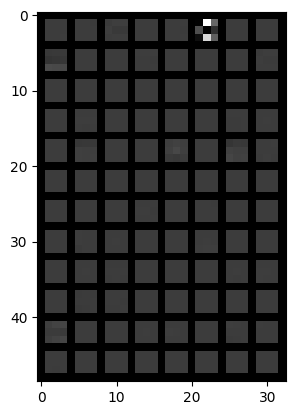

In [154]:
grid = torchvision.utils.make_grid(diffs.view(-1,1,3,3), normalize=True, scale_each=False, padding=1)
plt.imshow(grid.permute(1,2,0))

In [127]:
alpha

tensor([0.0306], requires_grad=True)

In [155]:
new = initial + alpha*ones

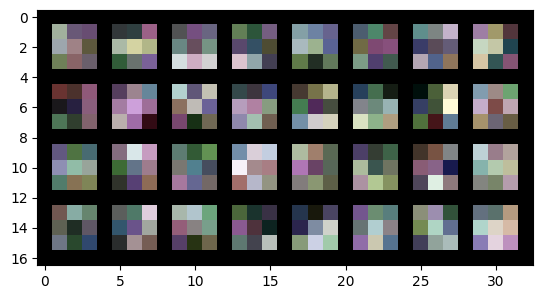

In [129]:
grid = torchvision.utils.make_grid(new.view(-1,3,3,3), normalize=True, scale_each=False, padding=1)
plt.imshow(grid.permute(1,2,0))

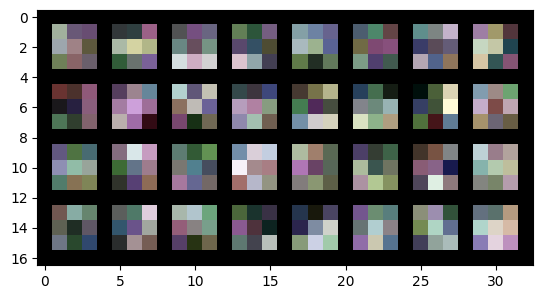

In [130]:
grid = torchvision.utils.make_grid(initial.view(-1,3,3,3), normalize=True, scale_each=False, padding=1)
plt.imshow(grid.permute(1,2,0))

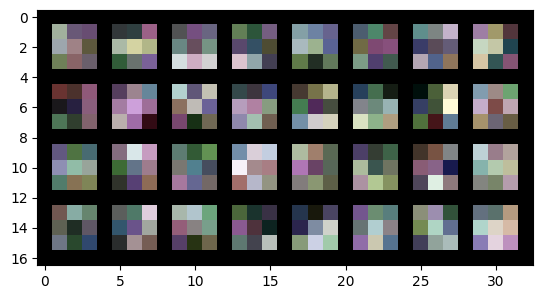

In [131]:
grid = torchvision.utils.make_grid(final.view(-1,3,3,3), normalize=True, scale_each=False, padding=1)
plt.imshow(grid.permute(1,2,0))

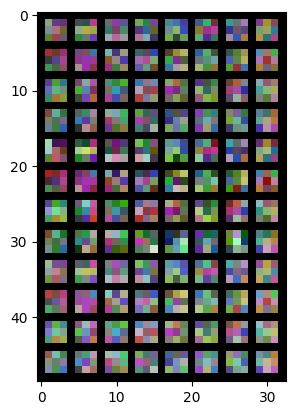

In [156]:
grid = torchvision.utils.make_grid(torch.stack([initial, final, new]).view(-1,3,3,3), normalize=True, scale_each=False, padding=1)
plt.imshow(grid.permute(1,2,0))

In [163]:
((final - new).abs()**2).sum()

tensor(5.2504, grad_fn=<SumBackward0>)

In [183]:
initial

tensor([[[ 6.2845e-02, -4.5363e-02, -2.2632e-02],
         [ 2.6676e-02,  1.6650e-01, -2.2817e-03],
         [-5.2383e-02,  9.8668e-02, -8.6139e-03]],

        [[ 1.4979e-01, -1.4632e-01, -1.7853e-01],
         [ 7.9201e-02, -3.9644e-03, -3.0029e-02],
         [ 5.0332e-02, -1.1756e-01, -7.2393e-02]],

        [[ 3.7550e-02,  3.6586e-02,  3.5288e-02],
         [ 1.2156e-01,  2.2230e-02, -1.8457e-01],
         [-1.8238e-01, -9.5612e-02, -1.3853e-03]],

        [[-1.2637e-01, -1.8593e-01,  1.8929e-01],
         [ 7.8823e-02,  1.7111e-01,  1.2356e-01],
         [-1.8375e-01, -3.2960e-02, -5.0377e-03]],

        [[-1.0041e-01, -9.2604e-02, -1.4816e-01],
         [ 1.6455e-01,  1.6500e-01,  1.5081e-01],
         [ 6.6923e-02,  2.0407e-02, -1.5165e-01]],

        [[-8.6478e-02, -8.6676e-02,  7.4532e-02],
         [ 5.4934e-02, -1.1928e-01, -1.1561e-01],
         [-1.3806e-01, -6.4163e-03,  1.7078e-01]],

        [[-1.9425e-02,  7.8055e-02, -5.7206e-02],
         [-1.6384e-01,  1.6999e-02, -1

In [140]:
final

tensor([[[ 0.1273, -0.1449, -0.0761],
         [ 0.1305,  0.1548, -0.0344],
         [-0.0497,  0.2065,  0.0361]],

        [[ 0.2882, -0.2504, -0.2767],
         [ 0.2493, -0.0283, -0.1359],
         [ 0.0496, -0.0644, -0.0871]],

        [[ 0.1665, -0.0654, -0.0474],
         [ 0.2789, -0.0050, -0.2678],
         [-0.1695, -0.0312,  0.0014]],

        [[-0.1625, -0.2728,  0.1740],
         [ 0.1432,  0.2655,  0.1964],
         [-0.2356, -0.0316, -0.0011]],

        [[-0.0596, -0.1008, -0.1924],
         [ 0.2591,  0.2964,  0.1797],
         [ 0.0646,  0.0343, -0.2244]],

        [[-0.1375, -0.1678,  0.0547],
         [ 0.0865, -0.0373, -0.0494],
         [-0.2167, -0.0207,  0.1550]],

        [[-0.0617,  0.0116, -0.0866],
         [-0.2454, -0.0192, -0.1383],
         [ 0.1725,  0.2702,  0.1382]],

        [[-0.0857, -0.2557, -0.1554],
         [-0.0835, -0.1953,  0.0154],
         [ 0.2311,  0.0706,  0.1310]],

        [[-0.0885,  0.0294,  0.0055],
         [-0.1160, -0.1100, -0.081

In [173]:
a = (torch.sign(initial) != torch.sign(final)).int()


In [168]:
final.shape

torch.Size([96, 3, 3])

In [169]:
769/(96*9)

0.8900462962962963

In [179]:
diff_init = (a*initial)[torch.where(a * initial != 0)]

In [180]:
diff_final = (a*final)[torch.where(a * final != 0)]

In [185]:
diff_init.abs().mean()

tensor(0.0262)

In [186]:
diff_final.abs().mean()

tensor(0.0346)